In [11]:
import polars as pl
from pathlib import Path
from prj.config import DATA_DIR
import gc
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import numpy as np

warnings.filterwarnings("ignore")

train_data_partitions = [x for x in (DATA_DIR / 'train').iterdir() if x.is_dir()]
train_data_partitions[-2:]

[PosixPath('/Users/lorecampa/Desktop/Projects/jane_street_forecasting/dataset/train/partition_id=3'),
 PosixPath('/Users/lorecampa/Desktop/Projects/jane_street_forecasting/dataset/train/partition_id=4')]

In [2]:
df = pl.read_parquet(train_data_partitions[-1] / 'part-0.parquet')
df.head(3)

date_id,time_id,symbol_id,weight,feature_00,feature_01,feature_02,feature_03,feature_04,feature_05,feature_06,feature_07,feature_08,feature_09,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,…,feature_51,feature_52,feature_53,feature_54,feature_55,feature_56,feature_57,feature_58,feature_59,feature_60,feature_61,feature_62,feature_63,feature_64,feature_65,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74,feature_75,feature_76,feature_77,feature_78,responder_0,responder_1,responder_2,responder_3,responder_4,responder_5,responder_6,responder_7,responder_8
i16,i16,i8,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,i8,i8,i16,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,…,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32
680,0,0,2.29816,0.851814,1.197591,0.219422,0.411698,2.057359,-0.542597,-3.4331,-1.090165,0.151888,11,7,76,-0.97142,0.670215,-0.502896,null,-0.070096,null,-1.308236,-2.120128,1.747068,-0.219661,0.791602,0.114922,-0.311672,0.156548,1.476346,1.301341,1.235173,-0.259882,-0.30125,-0.264237,null,…,0.322135,null,null,-2.273168,null,-1.627507,1.155271,null,-3.847984,-2.230864,-0.171579,-0.273791,-0.301876,-0.432933,-1.215778,-1.670469,-0.637963,0.803874,-0.21269,-0.764702,0.435278,-0.619145,null,null,-0.021034,-0.045094,-0.178144,-0.1951,-0.304665,0.164485,-0.205231,0.191064,-1.413209,0.375675,0.929775,-1.574939,1.101371
680,0,1,3.928745,0.534441,1.07974,0.038748,0.275343,2.135057,-0.541966,-2.774344,-1.048089,0.163768,11,7,76,-0.873847,1.794426,-0.226819,null,-0.328627,null,-0.870575,-1.204292,0.935869,-0.064365,1.273109,0.752816,-0.062281,0.687036,0.546603,1.229373,1.535235,-0.483758,-0.431013,-0.058963,null,…,0.505224,null,null,-1.074216,null,-1.909605,1.566016,null,-1.044804,-0.807186,-0.171579,-0.466983,-0.250124,-0.342297,-1.896279,-2.157645,-0.698755,1.743311,-0.069648,-0.933445,1.653637,-0.348816,null,null,-0.154413,-0.301091,-0.266495,-0.470271,0.089769,0.011395,0.092348,0.473781,0.397024,0.777026,0.826995,0.569681,1.986971
680,0,2,1.340433,-0.227643,0.764146,-0.243349,0.247027,2.347248,-0.478477,-2.660244,-1.261613,0.234425,81,2,59,-0.952889,-0.04806,-0.791763,null,-0.140953,null,-1.691419,-2.242023,-0.459649,-0.241993,-0.47108,-1.056603,-0.387841,-0.408962,0.359514,0.707161,0.669771,-0.641928,-0.645097,-0.362472,null,…,2.115924,null,null,0.095438,null,-0.664823,2.016616,null,2.085358,0.690842,-0.171579,0.022096,-0.018111,-0.015769,-2.270972,-1.826189,-0.908704,-0.051331,-0.658539,-1.011692,-0.008993,-0.363811,null,null,1.677642,1.705228,0.198109,0.152837,0.218281,0.060373,-0.164715,-0.132612,0.543831,-0.123519,-0.296969,0.547286,-0.049303


In [3]:
n_days = df['date_id'].n_unique()
n_days

170

In [4]:
unique_times_per_day = df.group_by('date_id').agg(pl.col('time_id').n_unique().alias('n_times')).sort('date_id')
unique_times_per_day['n_times'].min(), unique_times_per_day['n_times'].max()

(968, 968)

In [5]:
n_symbols_per_day_time = df.group_by(['date_id', 'time_id']).agg(pl.col('symbol_id').n_unique().alias('n_symbols')).sort(['date_id', 'time_id'])
n_symbols_per_day_time

date_id,time_id,n_symbols
i16,i16,u32
680,0,29
680,1,29
680,2,29
680,3,29
680,4,29
…,…,…
849,963,32
849,964,32
849,965,32


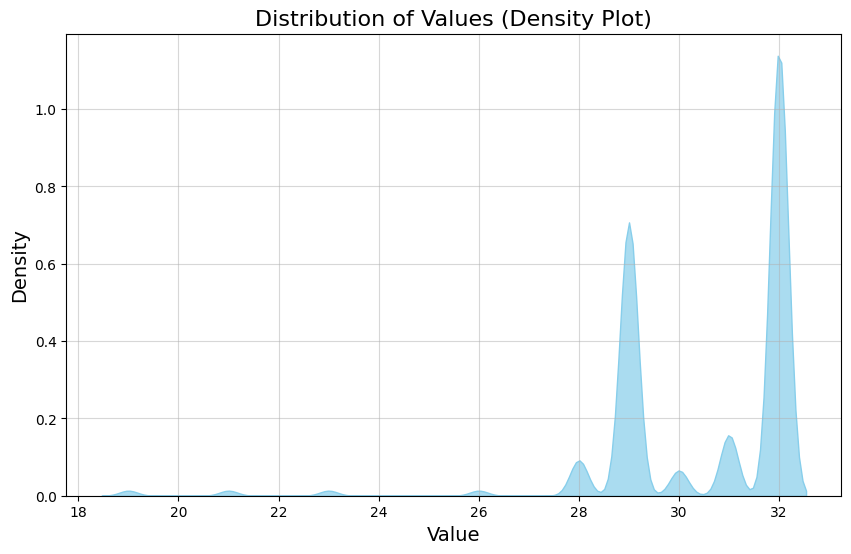

118

In [6]:
from prj.plots import plot_density


plot_density(n_symbols_per_day_time['n_symbols'])
del n_symbols_per_day_time
gc.collect()

In [7]:
features_cols = sorted([col for col in df.columns if col.startswith('feature_')], key=lambda x: int(x.split('_')[-1]))
responder_cols = sorted([col for col in df.columns if col.startswith('responder_')], key=lambda x: int(x.split('_')[-1]))
features_cols[:3], responder_cols[:3]

(['feature_00', 'feature_01', 'feature_02'],
 ['responder_0', 'responder_1', 'responder_2'])

In [8]:
symbols_weights = df.group_by('symbol_id').agg(
    pl.col('weight').sum().alias('total_weight'),
    pl.col('weight').mean().alias('mean_weight'),
    pl.col('weight').std().alias('std_weight'),
    pl.col('weight').min().alias('min_weight'),
    pl.col('weight').max().alias('max_weight'),
    pl.col('weight').quantile(0.25).alias('q25_weight'),
    pl.col('weight').quantile(0.5).alias('q50_weight'),
    pl.col('weight').quantile(0.75).alias('q75_weight'),
).sort('symbol_id')

symbols_weights.head(3)

symbol_id,total_weight,mean_weight,std_weight,min_weight,max_weight,q25_weight,q50_weight,q75_weight
i8,f32,f32,f32,f32,f32,f32,f32,f32
0,301888.8125,2.10722,0.411633,1.046415,3.203715,1.847406,2.093408,2.352752
1,500264.59375,3.040013,0.793379,1.411011,5.142856,2.468138,2.87426,3.609265
2,240916.359375,1.464003,0.240237,0.968106,2.239053,1.286922,1.441718,1.63951


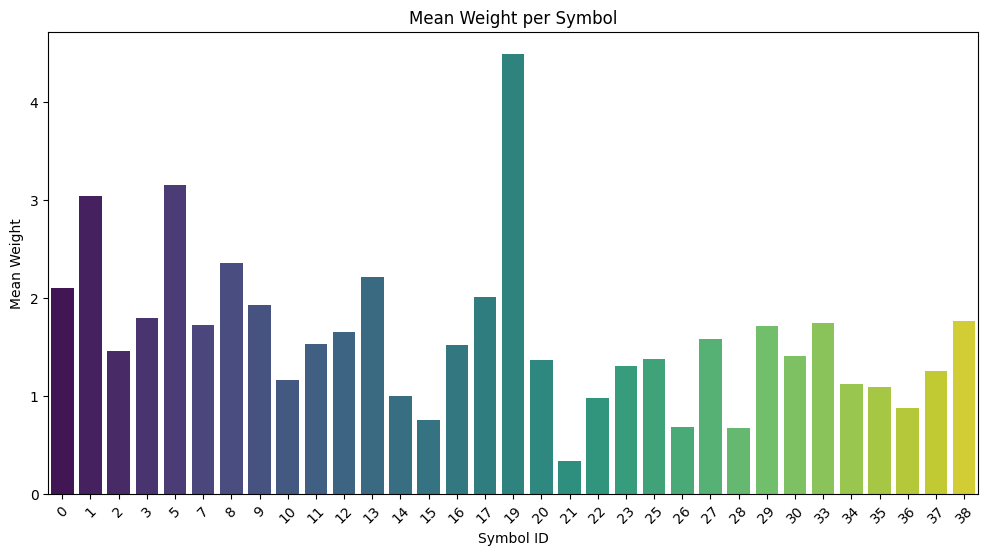

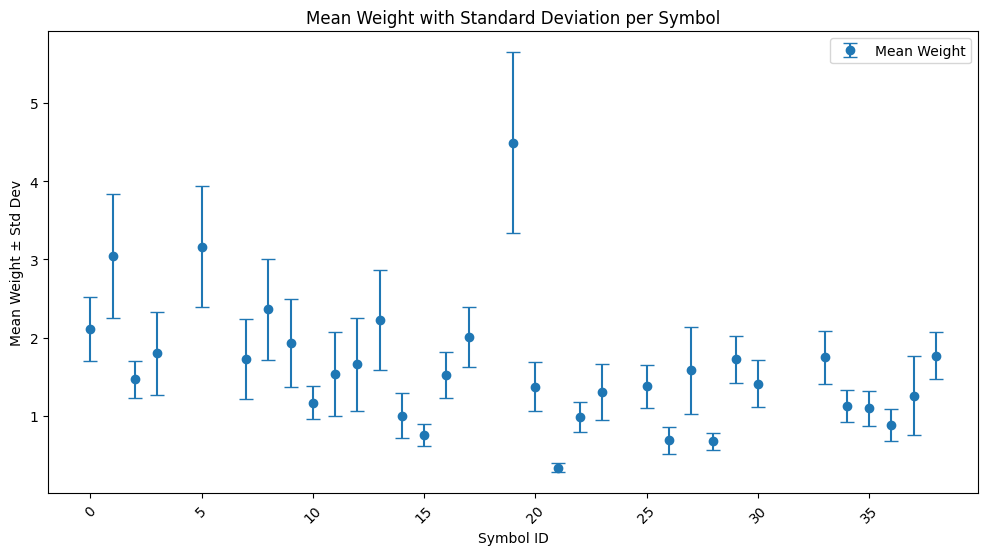

In [9]:
# Convert symbols_weights DataFrame to Pandas (assuming it's Polars DataFrame)
symbols_weights_pd = symbols_weights.to_pandas()

plt.figure(figsize=(12, 6))
sns.barplot(data=symbols_weights_pd, x='symbol_id', y='mean_weight', palette='viridis')
plt.title('Mean Weight per Symbol')
plt.xlabel('Symbol ID')
plt.ylabel('Mean Weight')
plt.xticks(rotation=45)
plt.show()

# 3. Scatter Plot for Mean Weights with Error Bars
plt.figure(figsize=(12, 6))
plt.errorbar(
    x=symbols_weights_pd['symbol_id'], 
    y=symbols_weights_pd['mean_weight'], 
    yerr=symbols_weights_pd['std_weight'], 
    fmt='o', capsize=5, label='Mean Weight'
)
plt.title('Mean Weight with Standard Deviation per Symbol')
plt.xlabel('Symbol ID')
plt.ylabel('Mean Weight ± Std Dev')
plt.xticks(rotation=45)
plt.legend()
plt.show()


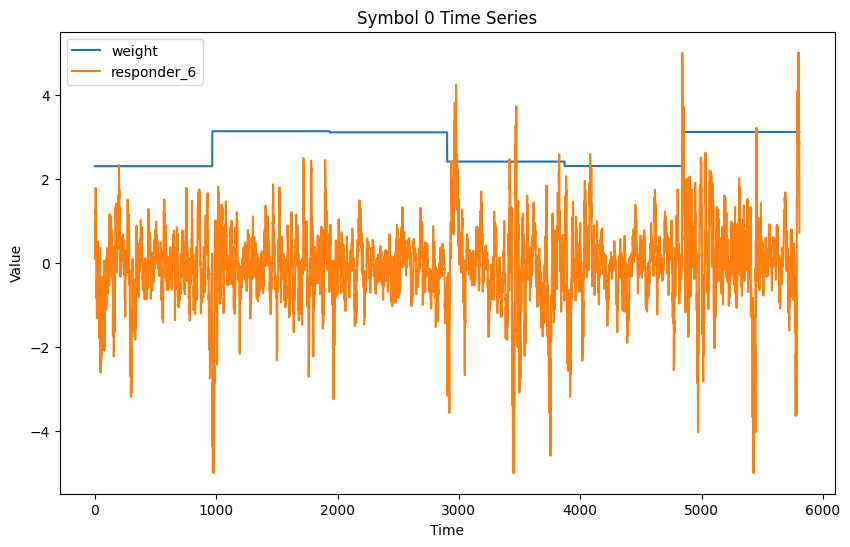

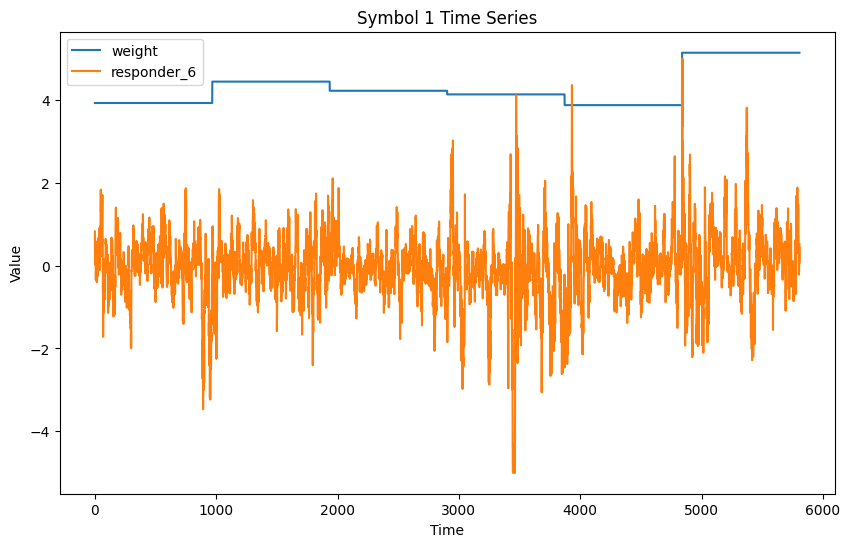

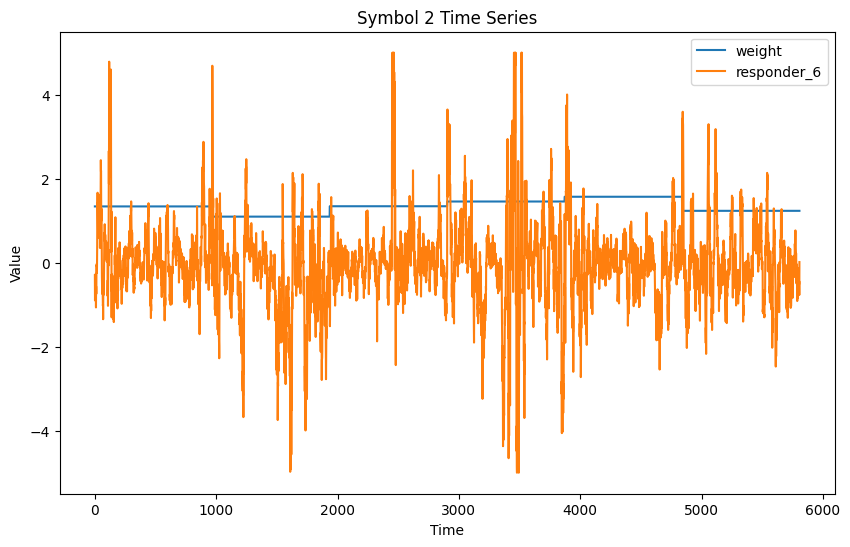

In [13]:
from prj.plots import plot_time_series


for symbol in [0, 1, 2]:
    cols = ['weight', 'responder_6']
    data = df.filter(pl.col('symbol_id') == symbol)\
        .filter(pl.col('date_id') <= pl.col('date_id').min() + 5)\
            .select(cols).to_numpy()  
    plot_time_series(data, labels=cols, times=np.arange(data.shape[0]), title=f'Symbol {symbol} Time Series')  